In [ ]:

!pip uninstall -y torch torchvision torchaudio transformers accelerate bitsandbytes


!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


!pip install -q --upgrade transformers datasets accelerate evaluate scikit-learn pandas openpyxl geopy sentence-transformers peft ftfy seaborn matplotlib bitsandbytes country_converter pycountry optuna




In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re
import time
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForSequenceClassification,
    pipeline,
    TrainingArguments,
    Trainer
)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from tqdm.auto import tqdm
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from sentence_transformers import SentenceTransformer, util
import ftfy
from peft import LoraConfig, get_peft_model, TaskType
import evaluate
import difflib
from getpass import getpass
from google.colab import userdata
import huggingface_hub
from torch import nn


In [ ]:
hf_token = userdata.get('HF_TOKEN').strip()
huggingface_hub.login(token=hf_token)


Successfully logged into Hugging Face.


In [ ]:
# test_df = pd.read_excel('news_classification_test_dataset.xlsx')
train_df = pd.read_excel('final_dataset.xlsx')
test_df = pd.read_excel('llama3_zeroshot_summary_results.xlsx') ## THIS INCLUDES THE SUMMARY

In [ ]:
def get_first_n_sentences(text: str, n: int = 5):

    return ". ".join(text.split('.')[:n]).strip() + "."




In [ ]:
def advanced_text_cleaner(text: str):

    text = ftfy.fix_text(text)


    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


    text = re.sub(r'\S*@\S*\s?', '', text, flags=re.MULTILINE)


    boilerplate_patterns = [
        r'Breaking News',
        r'Kindly share this story:',
        r'All rights reserved\.',
        r'This material, and other digital content on this website, may not be reproduced.*',
        r'punchng.com ©.*',
        r'Contact:.*'
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)


    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
def prepare_dataframe(df: pd.DataFrame, is_test_file=False):

    if is_test_file and df.shape[1] > 1:
        df.columns = df.iloc[0]


        df = df.drop(0)


        df = df.reset_index(drop=True)
        df['Article'] = df['Headline'].fillna('').astype(str) + '\n\n' + df['Content'].fillna('').astype(str)


    df['Article'] = df['Article'].apply(advanced_text_cleaner)
    final_df = df[['Article', 'Category']].copy()
    final_df.dropna(subset=['Category', 'Article'], inplace=True)
    # final_df['Article'] = final_df['Article'].apply(get_first_n_sentences)
    return final_df

train_df = prepare_dataframe(train_df)
test_df = test_df[['Final_Summary', 'Category']]
# train_df = train_df.sample(n=100, random_state=42).copy()
# test_df = test_df.sample(n=100, random_state=42).copy()

In [ ]:
test_df.head()

,Final_Summary,Category
0,The Kwara State Government has reopened the Kw...,Civil unrest
1,"Phrank Shaibu, Special Assistant to Atiku Abub...",Other
2,"Minister of Interior, Rauf Aregbesola, has emp...",Other
3,The Atiku-Okowa Presidential Campaign Organisa...,Other
4,Troops from Operation Forest Sanity neutralize...,Crime


In [ ]:
train_df.head()
train_df.shape

(1008, 2)

In [ ]:
test_df.head(20)

,Final_Summary,Category
0,The Kwara State Government has reopened the Kw...,Civil unrest
1,"Phrank Shaibu, Special Assistant to Atiku Abub...",Other
2,"Minister of Interior, Rauf Aregbesola, has emp...",Other
3,The Atiku-Okowa Presidential Campaign Organisa...,Other
4,Troops from Operation Forest Sanity neutralize...,Crime
5,"Primate Elijah Ayodele, leader of INRI Evangel...",Other
6,Edo State Governor Godwin Obaseki congratulate...,Other
7,A fatal road crash occurred on the Lagos-Ibada...,Road traffic accident
8,The Kogi State government has approved a 65-ye...,Other
9,"Two suspects, Nweke Joshua (19) and Chioma Oka...",Crime


In [ ]:
test_df.shape

(856, 2)

In [ ]:
train_df.shape

(1008, 2)

In [ ]:
categories = test_df['Category'].unique().tolist()

print(f"Data shape: {test_df.shape}")
print(f"Categories found: {categories}")


--- Test Data Ready ---
Data shape: (856, 2)
Categories found: ['Civil unrest', 'Other', 'Crime', 'Road traffic accident', 'Kidnapping', 'Environmental & Infrastructure', 'Terrorism and political violence acts', 'Medical']


# **FEW SHOT DYNAMIC PROMPTING TRIAL**

---



In [ ]:
tqdm.pandas()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16,bnb_4bit_quant_type="nf4")

trial_model = AutoModelForCausalLM.from_pretrained(MODEL_ID, quantization_config=quantization_config, device_map="auto")
trial_tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left",use_fast=True)



--- Loading Model: meta-llama/Meta-Llama-3-8B-Instruct ---


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded successfully.


In [ ]:
category_definitions = {

    "Terrorism and political violence acts":
        "Use when organised armed actors (militants, insurgents, separatists, unknown gunmen) "
        "attack civilians or state targets **to intimidate or coerce**. A clear political / "
        "ideological motive OR a pattern of armed raids counts, even if no ransom is demanded. "
        "EXCLUDE: hostage-taking for ransom only → Kidnapping; spontaneous crowds → Civil unrest.",

    "Kidnapping":
        "Any seizure or abduction of people (hostage-taking, crew hijack, child snatch, ‘one-chance’ robberies) "
        "where **the primary act is holding victims**. Motive may be ransom, robbery or revenge. "
        "EXCLUDE: abduction named as part of an armed political attack → Terrorism and political violence acts; no persons seized → Crime.",

    "Civil unrest":
        "Crowd actions such as protests, strikes, road blockages or riots **without organised use of guns or bombs**. "
        "EXCLUDE: armed assault or bomb attack during a protest → Terrorism and political violence acts; single-perpetrator thefts → Crime.",


    "Road traffic accident":
        "Unintentional collision or vehicle crash on roads causing injury, death or traffic delay. "
        "EXCLUDE: driver deliberately rams for ideological reasons → Terrorism and political violence acts; crash triggered by flood/landslide → Environmental & Infrastructure.",


    "Crime":
        "Any punishable act (theft, robbery, assault, fraud, homicide) **that is NOT abduction and NOT politically-motivated violence**. "
        "EXCLUDE: any hostage-taking → Kidnapping; attack by militants or insurgents → Terrorism and political violence acts.",


    "Environmental & Infrastructure":
        "Natural disasters (flood, storm, quake, wildfire, landslide) OR infrastructure / utility failures "
        "(bridge collapse, power-grid outage, dam burst, major road closure). "
        "EXCLUDE: routine vehicle crashes → Road traffic accident; stories focused on health policy → Medical.",


    "Medical":
        "Disease outbreaks, epidemics, infections, heatwaves, public-health advisories **and active health-emergency responses**. "
        "EXCLUDE: general health-agency staffing, budgets or lab upgrades with no urgent health threat → Other.",


    "Other":
        "Everything else: elections, economics, business, culture, science **unless** the story fits one of the definitions above. "
        "EXCLUDE: any article mentioning an abduction, armed attack, disease outbreak, natural disaster, or power/bridge failure.",
}
definitions_str = "\n".join([f"- '{name}': {desc}" for name, desc in category_definitions.items()])



In [ ]:
category_list_str = ", ".join(f"'{name}'" for name in categories)
def create_summarization_prompt(article_text: str, tokenizer):


    system_msg = (
        f"You are a world-class news editor. "
        f"Your task is to summarise the provided article in 3 concise, informative sentences "
        f"so the summary can later be classified into one of these predefined categories: "
        f"{category_list_str}."
    )

    messages = [
        {"role": "system", "content": system_msg},
        {
            "role": "user",
            "content": (
                "Please summarise the following article:\n\n"
                "---\n"
                f"{article_text}\n"
                "---"
            ),
        },
    ]


    return tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

In [ ]:
summary_pipeline = pipeline("text-generation", model=trial_model, tokenizer=trial_tokenizer)
if summary_pipeline.tokenizer.pad_token is None:
    summary_pipeline.tokenizer.pad_token = summary_pipeline.tokenizer.eos_token

Device set to use cuda:0


In [ ]:
from itertools import islice
from tqdm import tqdm

def _assistant_text(g):

    m = re.search(r"<\|start_header_id\|>assistant<\|end_header_id\|>(.*)", g, re.S)
    text = (m.group(1) if m else g).strip()


    text = re.sub(r"^\s*summary\s*:\s*", "", text, flags=re.I)
    return text.strip()

def _first_n_sentences(txt, n=3):

    sentences = re.split(r"(?<=[.!?])\s+(?=[A-Z])", txt)
    return " ".join(islice(sentences, n)).strip()

summarization_prompts = [
    create_summarization_prompt(a, trial_tokenizer)
    for a in train_df["Article"]
]

summary_raw = list(
    tqdm(
        summary_pipeline(
            summarization_prompts,
            max_new_tokens=150,
            do_sample=True,
            temperature = 0.3,
            top_p = 0.95,
            batch_size=16,
        ),
        total=len(summarization_prompts),
        desc="Summarizing",
    )
)


summaries = []
for raw, article in zip(summary_raw, train_df["Article"]):

    gen_txt = raw[0]["generated_text"] if isinstance(raw, list) else raw["generated_text"]
    summary = _assistant_text(gen_txt)

    if not summary:
        summary = _first_n_sentences(article, n=5)

    summaries.append(summary)

train_df["Generated_Summary"] = summaries


In [ ]:
train_df["Generated_Summary"]

,Generated_Summary
0,Here is a summary of the article in 3 concise ...
1,Here is a summary of the article in 3 concise ...
2,Here is a summary of the article in 3 concise ...
3,Here is a summary of the article in 3 concise ...
4,Here is a summary of the article in 3 concise ...
...,...
1003,Here is a summary of the article in 3 concise ...
1004,Here is a summary of the article in 3 concise ...
1005,Here is a summary of the article in 3 concise ...
1006,Here is a summary of the article in 3 concise ...


In [ ]:
boilerplate = re.compile(
    r"""
    ^\s*
    (?:
        # e.g. “Here is a brief summary of the article in three sentences:”
        (?:sure[,.!?\s]*)?
        (?:here|here's|here is|here are)\s*(?:a|the)?\s*
        (?:brief|concise|short)?\s*
        (?:summary|synopsis|overview)\b[^:.\n]{0,80}
        [:.\n]
        |
        summary\s*[:.\n]
        |
        tldr\s*[:.\n]
        |
        (?<!\S)>?\s*-\s*
    )
    """,
    re.IGNORECASE | re.VERBOSE,
)

def trim_to_summary(text: str, max_preamble_chars: int = 120):

    t = text.lstrip()

    m = boilerplate.match(t)
    if m:
        return t[m.end():].lstrip()

    dbl = re.search(r"\n\s*\n", t)
    if dbl and dbl.start() < max_preamble_chars:
        return t[dbl.end():].lstrip()

    return t

In [ ]:
train_df["Final_Summary"] = train_df["Generated_Summary"].apply(trim_to_summary)
train_df["Final_Summary"]

,Final_Summary
0,"A fatal stabbing occurred in Bamenda, Cameroon..."
1,Brazil's Federal Police seized 802 kg of cocai...
2,"Three warehouses in San Pedro Sula, Honduras, ..."
3,Four Chinese civil engineers and two Sudanese ...
4,A tour bus was hijacked on a highway in Acapul...
...,...
1003,A rupture in a 36-inch transmission line carry...
1004,"Palermo's mayor, Fabrizio Giordano, was arrest..."
1005,A surprise K-pop showcase by ShootingStar in S...
1006,A ransomware attack on two major transaction p...


In [ ]:
train_df["Final_Summary"][100]

"A payroll convoy carrying 179 million naira in salary funds was ambushed by masked gunmen near Gusau, Zamfara State, resulting in the deaths of two security guards and injuring six mine clerks. The attackers, believed to be linked to the 'Yan Binder' bandit network, made off with the cash box and abandoned a burnt motorcycle. The incident highlights the growing insecurity in north-west Nigeria, with bandits killing at least 1,360 civilians in 2024, and has led to the imposition of a curfew and military operations in the area."

In [ ]:
train_df['embeddings'] = train_df['Final_Summary'].progress_apply(lambda x: embedding_model.encode(x, convert_to_tensor=True))
train_df['embeddings']

  0%|          | 0/1008 [00:00<?, ?it/s]

,embeddings
0,"[tensor(0.0206, device='cuda:0'), tensor(0.086..."
1,"[tensor(-0.0330, device='cuda:0'), tensor(0.03..."
2,"[tensor(0.0405, device='cuda:0'), tensor(0.098..."
3,"[tensor(-0.0694, device='cuda:0'), tensor(0.10..."
4,"[tensor(-0.0248, device='cuda:0'), tensor(0.13..."
...,...
1003,"[tensor(-0.0674, device='cuda:0'), tensor(0.11..."
1004,"[tensor(-0.1031, device='cuda:0'), tensor(0.05..."
1005,"[tensor(0.0431, device='cuda:0'), tensor(0.029..."
1006,"[tensor(-0.0717, device='cuda:0'), tensor(0.05..."


In [ ]:
train_df.head()

,Article,Category,Generated_Summary,Final_Summary,embeddings
0,Fatal daytime stabbing shocks Bamenda market d...,Crime,Here is a summary of the article in 3 concise ...,"A fatal stabbing occurred in Bamenda, Cameroon...","[tensor(0.0206, device='cuda:0'), tensor(0.086..."
1,Rio police seize 800kg of cocaine after shooto...,Crime,Here is a summary of the article in 3 concise ...,Brazil's Federal Police seized 802 kg of cocai...,"[tensor(-0.0330, device='cuda:0'), tensor(0.03..."
2,Extortion‑linked arson wave guts San Pedro Sul...,Crime,Here is a summary of the article in 3 concise ...,"Three warehouses in San Pedro Sula, Honduras, ...","[tensor(0.0405, device='cuda:0'), tensor(0.098..."
3,Chinese engineers abducted from Darfur road pr...,Kidnapping,Here is a summary of the article in 3 concise ...,Four Chinese civil engineers and two Sudanese ...,"[tensor(-0.0694, device='cuda:0'), tensor(0.10..."
4,Tour bus hijacked outside Acapulco; 18 holiday...,Kidnapping,Here is a summary of the article in 3 concise ...,A tour bus was hijacked on a highway in Acapul...,"[tensor(-0.0248, device='cuda:0'), tensor(0.13..."


In [ ]:
def get_dynamic_examples(target_article_text, examples_df,k = 2):

  target_embedding = embedding_model.encode(target_article_text, convert_to_tensor=True)

  pool_embeddings = torch.stack(examples_df['embeddings'].tolist())

  cos_similarities = util.cos_sim(target_embedding, pool_embeddings)

  top_k_indices = torch.topk(cos_similarities.flatten(), k=k).indices.tolist()

  top_k_rows = examples_df.iloc[top_k_indices]

  return top_k_rows

In [ ]:
print(test_df['Final_Summary'][200])
examples = get_dynamic_examples(test_df['Final_Summary'][200],train_df,k=2)
examples

The Nigeria Centre for Disease Control (NCDC) has launched an online course on infection prevention and control (IPC) to educate citizens on the importance of wearing face masks to reduce the spread of COVID-19. The initiative is part of World Mask Week, a global campaign to promote the use of face masks as a key component of IPC procedures in medical and non-medical settings. The NCDC is partnering with various organizations to raise awareness on the importance of wearing face masks, which is critical in reducing the risk of COVID-19 infection and slowing the spread of the virus.


,Article,Category,Generated_Summary,Final_Summary,embeddings
652,Sudden yellow fever outbreak kills 14 in Bauch...,Medical,Here is a summary of the article in 3 concise ...,A sudden outbreak of yellow fever has occurred...,"[tensor(-0.0260, device='cuda:0'), tensor(0.00..."
884,DR Congo declares health emergency as Ebola re...,Medical,Here is a summary of the article in 3 concise ...,The Democratic Republic of Congo has declared ...,"[tensor(0.0131, device='cuda:0'), tensor(0.033..."


In [ ]:


tokenizer_fast = tokenizer_llm

def create_dynamic_fewshot_prompt(article_text: str,category_list: list[str],tokenizer,examples,k: int = 2,):

    few_shots_df = get_dynamic_examples(article_text, examples_df= examples, k=k)


    few_shots    = few_shots_df.to_dict("records")


    cats_json = ", ".join(f'"{c}"' for c in category_list)
    system_msg = (
        "You are a strict news-classification engine.\n"
        "• Reply with **exactly** ONE JSON object whose only key is \"label\".\n"
        f"• The value of \"label\" MUST be one of: [{cats_json}].\n"
        "• If uncertain, pick the single best-matching category.\n"
        "• Base your choice **ONLY on the definitions, the examples, and the article text**."
    )

    messages = [{"role": "system", "content": system_msg}]

    for shot in few_shots:
      messages.append(
            {"role": "user", "content": shot["Final_Summary"]}
        )

      messages.append(
            {"role": "assistant",
             "content": json.dumps({"label": shot["Category"]})}
        )



    user_msg = f"""
Definitions:
{definitions_str}

ARTICLE:
{article_text}

Reply ONLY with the JSON label.
""".strip()

    messages.append({"role": "user", "content": user_msg})


    prompt = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )




    prompt = prompt.replace(
        tokenizer.eos_token + "<|start_header_id|>assistant<|end_header_id|>",
        "<|start_header_id|>assistant<|end_header_id|>"
    )
    return prompt


def parse_llm_response(resp: str, valid_categories: list[str]) :

    _, _, assistant = resp.rpartition("<|start_header_id|>assistant<|end_header_id|>")
    if not assistant:
        assistant = resp


    for m in reversed(list(re.finditer(r"\{[^{}]*\}", assistant, flags=re.DOTALL))):
        try:
            label = json.loads(m.group())["label"].strip()
            if label in valid_categories:
                return label
        except Exception:
            continue

    pats = "|".join(re.escape(c) for c in valid_categories)
    m = re.search(rf"\b({pats})\b", assistant, flags=re.IGNORECASE)
    if m:
        return next(c for c in valid_categories if c.lower() == m.group(1).lower())

    print("\n\nResponse of the text: ", resp,"\n")
    return "Invalid Output"


def _fallback_best_match(text: str, valid_categories: list[str]) :

    match = difflib.get_close_matches(text, valid_categories, n=1, cutoff=0.0)
    print(match)
    return match[0] if match else "Invalid Output"

In [ ]:
MODEL_ID = "meta-llama/Meta-Llama-3-8B-Instruct"
BATCH_SIZE = 16

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


model_llm = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=quantization_config,
    device_map="auto",

)
tokenizer_llm = AutoTokenizer.from_pretrained(MODEL_ID)


In [ ]:
pipe = pipeline(
    "text-generation",
    model=model_llm,
    tokenizer=tokenizer_llm,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

if pipe.tokenizer.pad_token is None:
    pipe.tokenizer.pad_token = pipe.tokenizer.eos_token


In [ ]:


prompts = [create_dynamic_fewshot_prompt(summary, categories, tokenizer_llm,train_df, k = 1) for summary in test_df['Final_Summary']]
print(f"{len(prompts)} prompts created.")
prompts[1]

Creating  few-Shot prompts and starting batched inference...
856 prompts created.


'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a strict news-classification engine.\n• Reply with **exactly** ONE JSON object whose only key is "label".\n• The value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].\n• If uncertain, pick the single best-matching category.\n• Base your choice **ONLY on the definitions, the examples, and the article text**.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nColombian Mayor Mafe Bello resigned after being accused of steering a 15-year, $730,000 garbage collection contract to a company linked to her cousin in exchange for kickbacks to finance her election campaign. The contract, awarded in March, raised tariffs by 22% and was criticized for worsening service and enriching insiders. The scandal is the first major corruption case to affect a Generation-Z politician and has sparke

In [ ]:
outputs = pipe(prompts, max_new_tokens=100, do_sample=False  ,batch_size=BATCH_SIZE)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
The following generation flags are not valid and may

Batched inference complete.


In [ ]:
llm_predictions = [parse_llm_response(result[0]['generated_text'], categories) for result in tqdm(outputs, desc="Parsing results")]


Parsing results: 100%|██████████| 856/856 [00:00<00:00, 151682.48it/s]


In [ ]:
test_df['LLM_Predicted'] = llm_predictions
true_labels = test_df['Category']

In [ ]:

print("\n" + "="*80)
print(f" " * 15 + f"Final Performance Report for {MODEL_ID}")
print("="*80)

accuracy = accuracy_score(true_labels, llm_predictions)
f1_macro = f1_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
precision_macro = precision_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)
recall_macro = recall_score(true_labels, llm_predictions, average='macro', labels=categories, zero_division=0)

report_dict = {
    "accuracy": accuracy,
    "f1_macro": f1_macro,
    "precision_macro": precision_macro,
    "recall_macro": recall_macro
}

print("\n--- Key Performance Metrics ---")
for metric, value in report_dict.items():
    print(f"{metric:<18}: {value:.4f}")

all_possible_outcomes = categories + ['Invalid Output'] if 'Invalid Output' in set(llm_predictions) else categories
full_report = classification_report(
    true_labels,
    llm_predictions,
    labels=all_possible_outcomes,
    target_names=all_possible_outcomes,
    zero_division=0
)
print(full_report)
print("="*80)

try:
    test_df[['Final_Summary', 'Category', 'LLM_Predicted']].to_excel("llama3_zeroshot_results_classification.xlsx", index=False)
    print(f"\nFull results with predictions saved to 'llama3_zeroshot_results_colab.xlsx'")

except Exception as e:
    print(f"\nCould not save results to Excel. Error: {e}")


               Final Performance Report for meta-llama/Meta-Llama-3-8B-Instruct

--- Key Performance Metrics ---
accuracy          : 0.7734
f1_macro          : 0.7912
precision_macro   : 0.8161
recall_macro      : 0.7897

--- Detailed Classification Report (including invalid outputs) ---
                                       precision    recall  f1-score   support

                         Civil unrest       0.95      0.75      0.84       114
                                Other       0.77      0.65      0.71       201
                                Crime       0.61      0.85      0.71       101
                Road traffic accident       0.97      0.92      0.94        62
                           Kidnapping       0.95      0.73      0.83       111
       Environmental & Infrastructure       0.85      0.83      0.84        53
Terrorism and political violence acts       0.79      0.61      0.69        85
                              Medical       0.65      0.97      0.78       12

In [ ]:
for i, result in enumerate(outputs[:20]):
    raw_response_text = result[0]['generated_text']

    parsed_category = parse_llm_response(raw_response_text, categories)

    print(f"\n----------- Article {i+1} -----------")
    print(f"RAW OUTPUT:\n{repr(raw_response_text)}")
    print("-" * 20)
    print(f"PARSED RESULT: '{parsed_category}'")
    print("-" * 20)


--- Comparing Raw Output vs. Parsed Output ---

----------- Article 1 -----------
RAW OUTPUT:
'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are a strict news-classification engine.\n• Reply with **exactly** ONE JSON object whose only key is "label".\n• The value of "label" MUST be one of: ["Civil unrest", "Other", "Crime", "Road traffic accident", "Kidnapping", "Environmental & Infrastructure", "Terrorism and political violence acts", "Medical"].\n• If uncertain, pick the single best-matching category.\n• Base your choice **ONLY on the definitions, the examples, and the article text**.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nHundreds of students at the University of KwaZulu-Natal\'s Howard College campus have staged a week-long sit-in, occupying the administration block to demand the scrapping of penalty fees and the reinstatement of 45 deregistered peers. The protest has disrupted class timetables and led to scuffles with private security personnel,

In [ ]:

prediction_counts = test_df['LLM_Predicted'].value_counts()

print("--- Counts of Each Predicted Category ---")
print(prediction_counts)

--- Counts of Each Predicted Category ---
LLM_Predicted
Medical                                  191
Other                                    170
Crime                                    142
Civil unrest                              91
Kidnapping                                85
Terrorism and political violence acts     66
Road traffic accident                     59
Environmental & Infrastructure            52
Name: count, dtype: int64


--- Generating Confusion Matrix ---

Confusion Matrix (Raw Counts):
                                       Civil unrest  Other  Crime  \
Civil unrest                                     86     19      4   
Other                                             0    131      3   
Crime                                             1      6     86   
Road traffic accident                             0      3      1   
Kidnapping                                        0      5     19   
Environmental & Infrastructure                    2      1      2   
Terrorism and political violence acts             2      1     27   
Medical                                           0      4      0   

                                       Road traffic accident  Kidnapping  \
Civil unrest                                               0           0   
Other                                                      0           0   
Crime                                                      0           2   
Road t

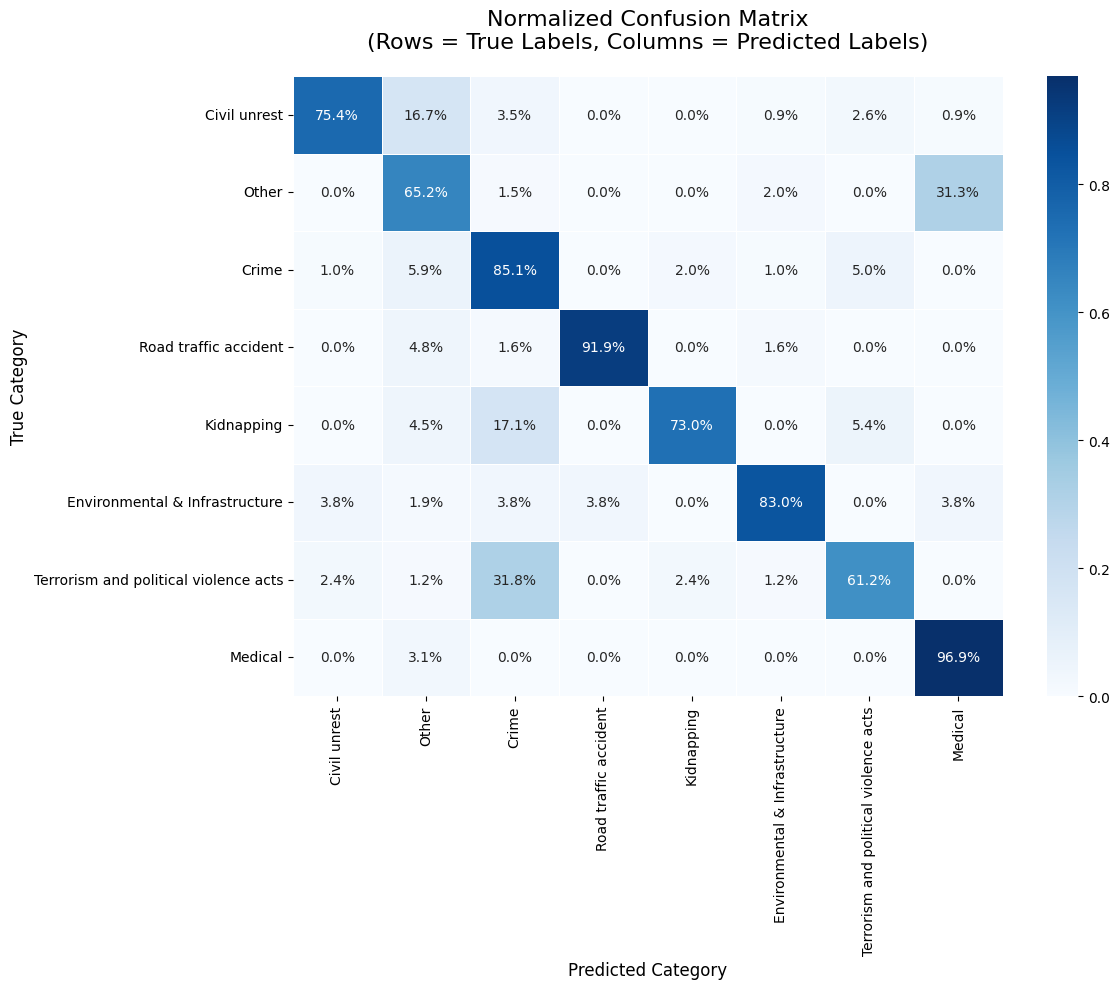

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(true_labels, llm_predictions, labels=categories)


cm_df = pd.DataFrame(cm, index=categories, columns=categories)

print("\nConfusion Matrix (Raw Counts):")
print(cm_df)



cm_normalized = cm_df.div(cm_df.sum(axis=1), axis=0)



plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.1%',
    cmap='Blues',
    linewidths=.5
)

heatmap.set_title('Normalized Confusion Matrix\n(Rows = True Labels, Columns = Predicted Labels)', fontsize=16, pad=20)
heatmap.set_xlabel('Predicted Category', fontsize=12)
heatmap.set_ylabel('True Category', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
train_df.to_excel("train_df_summary.xlsx", index=False)